In [1]:
from multiarmed import MultiArmedBandit
import sys
sys.path.append("../ES")
from ES_NeuralGraph import NeuralGraph
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [2]:
# IM SO DUMB.  THE OTHER THING THIS SYSTEM NEEDS TO KNOW IS IT'S PREV ACTION WHICH IT DOESN'T SINCE I AM SAMPLING IT...
# GONNA USE LABEL TO ACCOMPLISH THIS


n_inp = 1 # Reward is input and gonna give it two random nodes: one unif 0-1 and one norm(0, 1)
n_hid = 0
n_out = 2

n_nodes = n_out + n_hid + n_inp

device = "cuda" if torch.cuda.is_available() else "cpu"

# connections = torch.Tensor([[i, j] for i in range(n_nodes) for j in range(n_nodes)]).long().to(device)

# Only have one way connections from inps to actions
# connections = torch.Tensor([[i, j] for i in range(n_nodes) for j in range(n_nodes)]).long().to(device)
connections = torch.Tensor([[0, 1], [0, 2]]).long().to(device)


print(len(connections))

graph = NeuralGraph(n_nodes, n_inp, n_out, connections, ch_n=8, ch_e=8, clamp_mode="hard", max_value=100, init_mode="trainable", set_nodes=True, aggregation="mean", 
                     use_label=True, n_models=1).to(device)

env = MultiArmedBandit(device=device, n=n_out)

optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

log = []

sigma = .05

2


In [6]:
EPOCHS = 100_000
STEPS = 32

BATCH_SIZE = 4096
TIME = 4
DT = 1

bar = tqdm(range(EPOCHS))

for _ in bar:
    with torch.no_grad():

        graph.generate_epsilons(BATCH_SIZE, sigma=sigma)
        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
        best_mus, best_actions = env.initialize(BATCH_SIZE)

        # print(env.mus)
        # assert False

        reward = torch.zeros(BATCH_SIZE).to(device)
        optimizer.zero_grad()

        regret = torch.zeros(BATCH_SIZE).to(device)

        accs = torch.zeros(BATCH_SIZE).to(device)

        for _ in range(STEPS):
            # Get action
            timesteps = round(TIME / DT)
            for t in range(timesteps):
                graph.timestep(step_nodes=True, step_edges=False, dt=DT, t=t)
            action_dist = graph.read_outputs().softmax(-1)

            # Sample from action distribution
            action = torch.multinomial(action_dist, 1).squeeze(-1) # action_dist.argmax(-1)

            reward = env.step(action)

            # Let the model see the resulting reward and also the action that was actually taken
            graph.backward(reward.unsqueeze(1), nn.functional.one_hot(action, n_out), TIME, DT, apply_once=False, nodes=True, edges=True)
            
            # inp = torch.stack([, torch.randn(BATCH_SIZE).to(device), torch.rand(BATCH_SIZE).to(device)], dim=1)
            # action_dist = graph.forward(reward.unsqueeze(1), TIME, DT, apply_once=True, nodes=True, edges=True).softmax(-1)
            
            accs += (best_actions == action_dist.argmax(-1)).float() / STEPS # Do accuracy with actual choice, and step env probabilistically

            regret += (best_mus - reward) / STEPS
        
        overflows = torch.where(graph.nodes.abs() > 5, graph.nodes.abs(), 0).mean(-1).mean(-1) + torch.where(graph.nodes.abs() > 5, graph.nodes.abs(), 0).mean(-1).mean(-1)
        overflow = overflows.mean().item()

        graph.estimate_grads(regret - accs + overflows, normalize=True, sigma=sigma)

        optimizer.step()

        entry = {"Regret":regret.mean().item(), "Acc":accs.mean().item(), "Overflow":overflow}

        log.append(entry)

        bar.set_postfix(entry)

 62%|██████▏   | 62300/100000 [10:42:30<6:28:48,  1.62it/s, Regret=0.0153, Acc=0.985, Overflow=0]       


KeyboardInterrupt: 

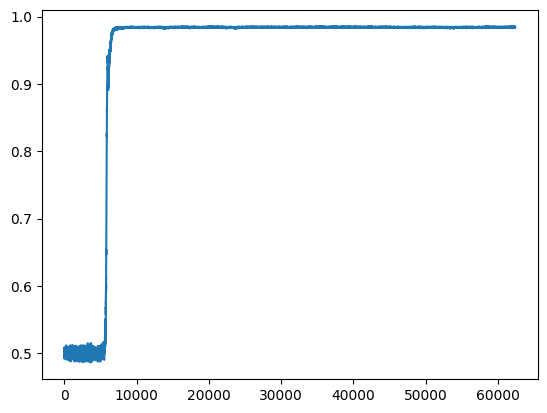

In [7]:
plt.plot([e["Acc"] for e in log])

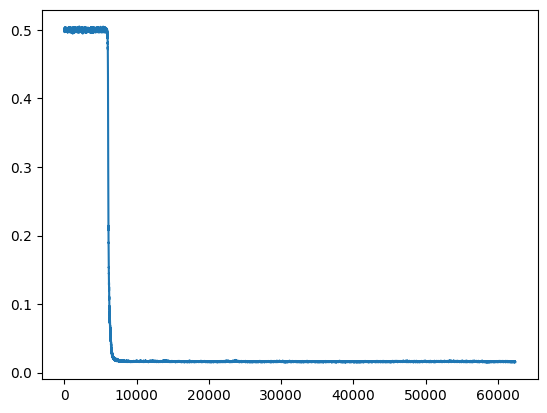

In [9]:
plt.plot([e["Regret"] for e in log])

In [10]:
torch.save(graph, "multi.pt")

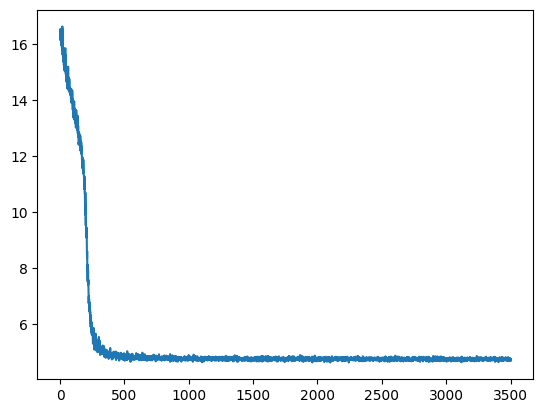

In [11]:
plt.plot(log)